# Tests using the new data class

In [22]:
import os
import pandas as pd

import sys
sys.path.insert(0, "/home/usuario/project/src")

%load_ext autoreload
%autoreload

from kalmanfiltermotion import KalmanMotionTracker
from dataset import Route

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
home_path = '/home/usuario/'

datasets_path = os.path.join(home_path, 'project_data', 'datasets')

all_datasets = ['KITTITrackletsCars', 'KITTITrackletsCarsPersons', 'KITTITrackletsCarsHard', 'KITTITrackletsCarsPersonsHard']

In [24]:
# This is the output from the NN
predictions = pd.read_csv(os.path.join(datasets_path, all_datasets[0], "NN_output.csv"))
# This gives information about the paths
eval_info = pd.read_csv(os.path.join(datasets_path, all_datasets[0], "info_eval.csv"))

In [25]:
# Angles correction Reduces the MSE from 200 to 66 degrees.
predictions.loc[predictions['pred_angles']>3, 'pred_angles'] = predictions[predictions['pred_angles']>3]['pred_angles'] - 3
predictions.loc[predictions['pred_angles']<-3, 'pred_angles'] = predictions[predictions['pred_angles']<-3]['pred_angles'] + 3

In [26]:
def routes_to_dict(eval_info, predictions):
    ''' Loads (meta)info from disk to memory classes for easy manipulation '''
    routes = dict()
    n_routes = eval_info.shape[0]
    
    for i in range(n_routes):
        current = eval_info.iloc[i]
        start_i = current['cumsum']
        end_i = start_i + current['n_points']
        current_pred = predictions.iloc[start_i:end_i]
        
        route_obj = Route(current['name'], current_pred)
        
        routes[current['name']] = route_obj
            
    return routes

In [27]:
routes_dict = routes_to_dict(eval_info, predictions)

In [28]:
for key, route in routes_dict.items():
    
    # nn predictions come from neural network! (input data to this script)
    
    # make kf predictions
    route.run_kalman_filter('nn')
    
    # make nn routes
    route.make_route('nn')
    route.make_fake_route('nn')
    
    # make kf routes
    route.make_route('kf')
    route.make_fake_route('kf')
    
    # compute nn error
    route.compute_rmse_error('nn_f')
    route.compute_rmse_error('nn_r')
    
    # compute kf error
    route.compute_rmse_error('kf_f')
    route.compute_rmse_error('kf_r')


In [41]:
import matplotlib.pyplot as plt
from matplotlib import patches

#%matplotlib notebook
#plt.rcParams['figure.figsize'] = 8, 8

import mpld3
mpld3.enable_notebook()
plt.rcParams['figure.figsize'] = 10,10

In [58]:
def plot_route(route, arrows=False):
    """ Plots given route from DataFrame
        Show both the ground truth and the predicted
    """
    fig, ax = plt.subplots()
    
    colours=['orange', 'red', 'green', 'blue', 'pink', 'yellow', 'cyan']
    
    ax.plot(route.routes['gt_x'], route.routes['gt_y'], '-ok', color='black')
    for i, name in enumerate(['nn_r', 'nn_f', 'kf_r', 'kf_f']):
        ax.plot(route.routes[f'{name}_x'], route.routes[f'{name}_y'], '-ok', color=colours[i], label=f'{name} RMSE: {route.trans_error[name]:.4f}')
        
        
    if arrows:
        # Add the arrows
        for posx, posy, ang in zip(pc_p[0], pc_p[1], pc_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'black', mean_dist/7))
        for posx, posy, ang in zip(pr_p[0], pr_p[1], pr_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'orange', mean_dist/7))
        for posx, posy, ang in zip(kf_p[0], kf_p[1], kf_a):
            ax.add_patch(create_arrow(posx, posy, ang, 'red', mean_dist/7))

    ax.legend(prop={'size': 15})

    # Set title to the plot
    ax.set_title(f"route: {route.name}", size=20)
   

In [60]:
i = 0

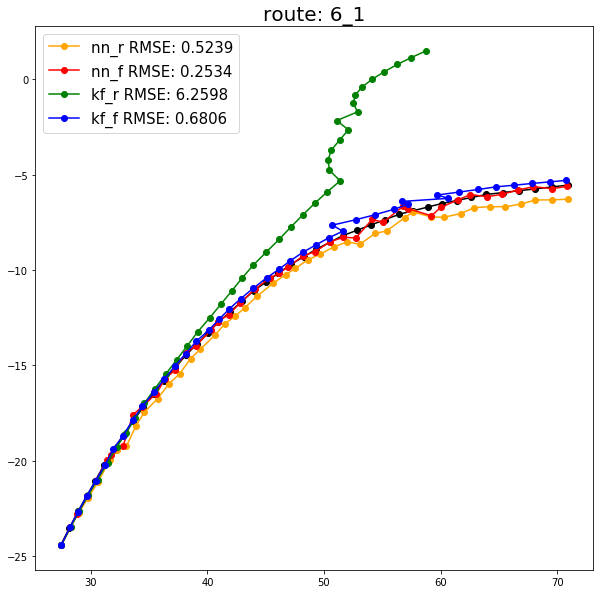

In [81]:
plot_route(routes_dict[list(routes_dict.keys())[i]])
i += 1